In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import re
import nltk
import math
import os
import matplotlib.pyplot as plt
import sklearn.metrics

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import Perceptron

from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import pickle

%matplotlib inline


## Load csv files

In [2]:
proteins = pd.read_csv('protein-SevenLocations-Feb12.csv')

proteins.head()

,name,sequence,location,label
0,tr|A0A0N4VT99|A0A0N4VT99_HAEPC,LLFVWLPQFIVRPHALLRFWMETDCQGNPPMYGDFEAQRHWMEITI...,0,ER
1,tr|A0A3P8RTP6|A0A3P8RTP6_AMPPE,MGRCVFLILAVLFSVTSSQFIPPYTEDCRTEMYPPKGPTYRGAVGW...,3,lysosome
2,sp|O89290|POL_HV193,MGARASVLSGGKLDAWEKIRLRPGGKKKYRLKHLVWASRELERFAL...,6,plasma_membrane
3,tr|S2JAV3|S2JAV3_MUCC1,MVKKQKKKQPITARVQPTEAKFKHSRVETARLIRKFHVLNKELAKC...,5,nucleus
4,sp|A5I7A5|UVRC_CLOBH,MFDLEYQLKNLPDKPGVYLMKNNLGEIIYVGKAKILKNRVRQYFQK...,2,cytoplasm


In [3]:
proteins.shape

(700483, 4)

In [4]:
# permute/scramble/shuffle rows of the dataframe
proteins = proteins.sample(frac=1)

In [5]:
proteins.location.value_counts()

5    178929
0    118331
4    109750
2     97116
1     75188
3     60911
6     60258
Name: location, dtype: int64

In [6]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

In [7]:
# remove the duplicate protein sequences
proteins = proteins.drop_duplicates(subset='sequence', keep="first")

# remove nan from 'sequence' column
proteins = proteins[proteins['sequence'].notnull()]

proteins.shape

(700483, 4)

In [8]:
proteins.label.value_counts()

nucleus            178929
ER                 118331
mitochondria       109750
cytoplasm           97116
Golgi               75188
lysosome            60911
plasma_membrane     60258
Name: label, dtype: int64

## Transform the protein sequence data with CountVectorizer to get peptide frequency. Split the data into training & test sets.

In [9]:
# Peptide count is used for analysis
peptide_size = 6
vect = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))

In [10]:
X = vect.fit_transform(proteins.sequence)
y = proteins.location

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state =42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

((560386, 34701392), (560386,))
((140097, 34701392), (140097,))


In [12]:
y_test.value_counts()

5    35797
0    23503
4    21923
2    19528
1    15083
6    12199
3    12064
Name: location, dtype: int64

## Classifiers

## Majority Vote Classifiers

In [13]:
# three classifiers: SGD, PassiveAggressiveClassifier, MNB

clf1 = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2 = PassiveAggressiveClassifier()
clf3 = MultinomialNB()

In [14]:
eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('pac', clf2), ('mnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf1.score(X_test, y_test)))

/Users/scottlew/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Majority Voting Classifier Score: 0.94


In [15]:
# Generate Confusion Matrix 
actual = y_test
predictions = eclf1.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22512   331    92    21    92   199   256]
 [  330 14488    52    24    25   117    47]
 [   30    12 17796    28   158  1200   304]
 [   34    18    91 11643     6   142   130]
 [   82    10   419    22 20469   662   259]
 [   67     6   731    37   159 34463   334]
 [   71    17   498   103   106   629 10775]]


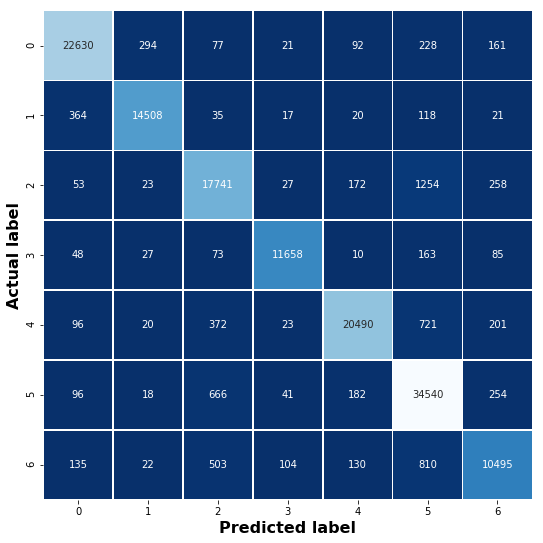

In [31]:
# Confusion matrix 1 made pretty for Capstone report

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=16,fontweight='bold');
plt.xlabel('Predicted label',fontsize=16,fontweight='bold');
#plt.ylabel('Actual label');
#plt.xlabel('Predicted label');
plt.savefig('ConfusionMatrix_VotingClassifier_Locations_Model_1.png')

In [17]:
vote_prediction1 = eclf1.predict(X_test)
print(classification_report(vote_prediction1, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     23126
           1       0.96      0.97      0.97     14882
           2       0.91      0.90      0.91     19679
           3       0.97      0.98      0.97     11878
           4       0.93      0.97      0.95     21015
           5       0.96      0.92      0.94     37412
           6       0.88      0.89      0.89     12105

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.95      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [18]:
%%time
clf1a = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2a = PassiveAggressiveClassifier(C=0.1)
clf3a = MultinomialNB(alpha=50)

eclf2 = VotingClassifier(estimators=[('sgd', clf1a), ('pac', clf2a), ('mnb', clf3a)], voting='hard')
eclf2.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf2.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.94
()
CPU times: user 12min 18s, sys: 1min 11s, total: 13min 30s
Wall time: 14min 57s


In [19]:
vote_prediction2 = eclf2.predict(X_test)
print(classification_report(vote_prediction2, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23262
           1       0.96      0.97      0.97     14934
           2       0.91      0.92      0.91     19253
           3       0.96      0.98      0.97     11840
           4       0.93      0.97      0.95     21001
           5       0.97      0.91      0.94     38204
           6       0.87      0.91      0.89     11603

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.95      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [20]:
# Generate Confusion Matrix 2
actual = y_test
predictions = eclf2.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22531   335    73    20    97   256   191]
 [  321 14516    38    22    25   143    18]
 [   46    15 17678    28   152  1345   264]
 [   63    20    61 11612    12   199    97]
 [   98    14   348    20 20445   790   208]
 [   94    12   587    36   156 34661   251]
 [  109    22   468   102   114   810 10574]]


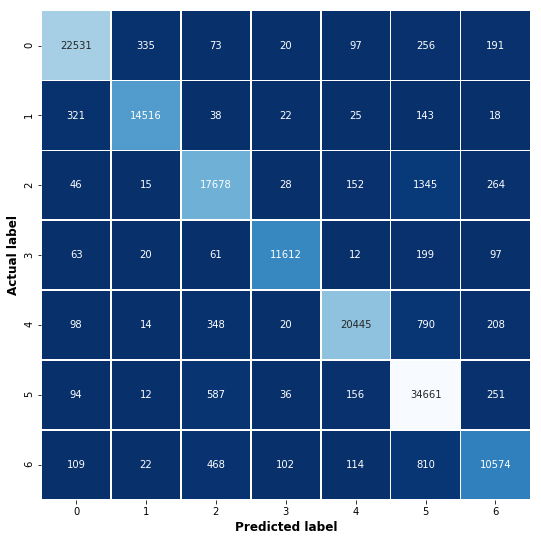

In [21]:
# Confusion matrix 2 made pretty for Capstone report

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=12,fontweight='bold');
plt.xlabel('Predicted label',fontsize=12,fontweight='bold');

#plt.savefig('ConfusionMatrix_VotingClassifier_Locations_3.png')

In [22]:
%%time
clf1d = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)
clf2d = PassiveAggressiveClassifier(C=0.1)
clf3d = Perceptron(tol=1e-3, random_state=0)
clf4d = MultinomialNB(alpha=50)

eclf3 = VotingClassifier(estimators=[('sgd', clf1d), ('pac', clf2d), ('per', clf3d),('mnb',clf4d)], voting='hard')
eclf3.fit(X_train, y_train)
# evaluate accuracy of our model on test data
print("Majority Voting Classifier Score: {:.2f}".format(eclf3.score(X_test, y_test)))
print()

Majority Voting Classifier Score: 0.94
()
CPU times: user 29min 19s, sys: 1min 31s, total: 30min 51s
Wall time: 1h 6min 3s


In [23]:
vote_prediction3 = eclf3.predict(X_test)
print(classification_report(vote_prediction3, y_test))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23422
           1       0.96      0.97      0.97     14912
           2       0.91      0.91      0.91     19467
           3       0.97      0.98      0.97     11891
           4       0.93      0.97      0.95     21096
           5       0.96      0.91      0.94     37834
           6       0.86      0.91      0.89     11475

   micro avg       0.94      0.94      0.94    140097
   macro avg       0.94      0.95      0.94    140097
weighted avg       0.94      0.94      0.94    140097



In [24]:
# Generate Confusion Matrix 3
actual = y_test
predictions = eclf3.predict(X_test)
print('Confusion Matrix for Majority Vote Model')
print()
cm = confusion_matrix(actual,predictions)
print(cm)

Confusion Matrix for Majority Vote Model
()
[[22630   294    77    21    92   228   161]
 [  364 14508    35    17    20   118    21]
 [   53    23 17741    27   172  1254   258]
 [   48    27    73 11658    10   163    85]
 [   96    20   372    23 20490   721   201]
 [   96    18   666    41   182 34540   254]
 [  135    22   503   104   130   810 10495]]


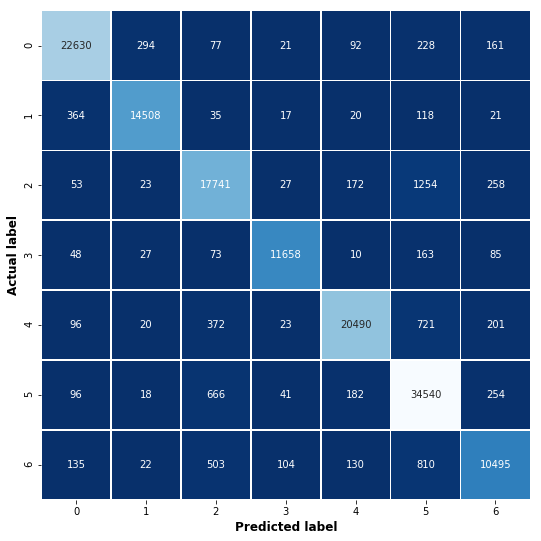

In [25]:
# Confusion matrix 3 made pretty for Capstone report

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r',cbar= None);
plt.ylabel('Actual label',fontsize=12,fontweight='bold');
plt.xlabel('Predicted label',fontsize=12,fontweight='bold');
#plt.savefig('ConfusionMatrix_VotingClassifier_Locations_3.png')